In [1]:
import cell_lineage_tracking as lineage
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
torch.set_default_dtype(torch.float32)
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import BaseTransform
import torch.nn as nn
from torch.utils.data import Subset

In [2]:
train_cells_filename = '/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_tracking_training_data.pkl'
all_lineages_df = pd.read_pickle(train_cells_filename)

In [3]:
# baeS tracked lineage had cells that didn't grow well
df_for_training = all_lineages_df[~(all_lineages_df['gene'] == 'baeS')]

In [4]:
# give ground truth lineages unqiue ids
df_for_training['unique_lineages'] = df_for_training['experiment_name'].astype(str) + '_' + df_for_training['trench_id'].astype(str) + '_' + df_for_training['ground_truth_lineage'].astype(str)
# Convert lineage IDs to unique integers as labels
all_unique_lineages = sorted(df_for_training['unique_lineages'].unique())
lineage_to_int_mapping = {lineage: i for i, lineage in enumerate(all_unique_lineages)}
num_lineage_classes = len(all_unique_lineages)
df_for_training['numeric_lineage'] = df_for_training['unique_lineages'].map(lineage_to_int_mapping)
df_for_training['node_id'] = df_for_training.index

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_35219/592007538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_training['unique_lineages'] = df_for_training['experiment_name'].astype(str) + '_' + df_for_training['trench_id'].astype(str) + '_' + df_for_training['ground_truth_lineage'].astype(str)
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_35219/592007538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_training['numeric_lineage'] = df_for_training['unique_line

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
node_feature_cols = ['area', 'centroid_y', 
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor']
for col in node_feature_cols:
    df_for_training[col] = df_for_training[col].astype(np.float32);   

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_35219/2254400331.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_training[col] = df_for_training[col].astype(np.float32);
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_35219/2254400331.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_training[col] = df_for_training[col].astype(np.float32);
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_35219/2254400331.py:6: SettingWithCopyWarning: 
A value is trying to 

In [7]:
all_fov_dataframes = []

# Identify unique FOV/trench combinations
unique_fovs = df_for_training[['experiment_name', 'FOV', 'trench_id']].drop_duplicates().to_records(index=False)

for exp, fov, trench in unique_fovs:
    # Filter the DataFrame to get ALL cells within this FOV/trench
    df_fov_trench = df_for_training[
        (df_for_training['experiment_name'] == exp) &
        (df_for_training['FOV'] == fov) &
        (df_for_training['trench_id'] == trench)
    ].copy()

    # Append the DataFrame to your list
    all_fov_dataframes.append(df_fov_trench)

print(f"Total number of FOV DataFrames collected: {len(all_fov_dataframes)}")

Total number of FOV DataFrames collected: 10


In [8]:
# Split the list of FOV DataFrames
train_fovs, temp_fovs = train_test_split(all_fov_dataframes, test_size=0.4, random_state=42)
val_fovs, test_fovs = train_test_split(temp_fovs, test_size=0.5, random_state=42)

print(f"Number of training FOVs: {len(train_fovs)}")
print(f"Number of validation FOVs: {len(val_fovs)}")
print(f"Number of test FOVs: {len(test_fovs)}")

Number of training FOVs: 6
Number of validation FOVs: 2
Number of test FOVs: 2


In [9]:
all_train_node_features = []

for fov_df in train_fovs:
    # Create a temporary PyG Data object for each FOV to access its node features.
    temp_graph = lineage.create_fov_graph(fov_df, node_feature_cols, device=device)
    if temp_graph is not None:
        # Append the node features as a NumPy array.
        all_train_node_features.append(temp_graph.x.cpu().numpy())

# Concatenate all training node features into a single NumPy array.
all_train_node_features_np = np.concatenate(all_train_node_features, axis=0)

# Initialize and fit the scaler on the training data.
scaler = StandardScaler()
scaler.fit(all_train_node_features_np)
print("Scaler fitted on training data.")

Scaler fitted on training data.


In [10]:
# Create an instance of the transform with the fitted scaler, doing this split here to prevent data leakage that happens when i spli graphs randomly
transform = lineage.StandardScalerTransform(scaler)
train_dataset = lineage.CellTrackingDataset(root='./processed_data/train',
                                    df_cells=pd.concat(train_fovs),
                                    node_feature_cols=node_feature_cols,
                                    device=device,
                                    pre_transform=transform) # Apply the scaling transform here

val_dataset = lineage.CellTrackingDataset(root='./processed_data/val',
                                  df_cells=pd.concat(val_fovs),
                                  node_feature_cols=node_feature_cols,
                                  device=device,
                                  pre_transform=transform)

test_dataset = lineage.CellTrackingDataset(root='./processed_data/test',
                                   df_cells=pd.concat(test_fovs),
                                   node_feature_cols=node_feature_cols,
                                   device=device,
                                   pre_transform=transform)

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Number of training graphs: 6
Number of validation graphs: 2
Number of test graphs: 2


In [12]:
num_batches = 0
for batch_data in train_loader:
    num_batches += 1
    print(f"Batch {num_batches}:")
    print(f"  - Number of nodes: {batch_data.num_nodes}")
    print(f"  - Number of edges (positive): {batch_data.edge_index.size(1)}")
    # Optional: Print some node features to confirm the scaling worked
    print(f"  - First 5 node features: {batch_data.x[:5]}")
    if num_batches >= 1: # You can stop after the first batch
        break

if num_batches == 0:
    print("The train_loader is empty.")
else:
    print(f"\nSuccessfully iterated through {num_batches} batch(es). The loader contains data.")

Batch 1:
  - Number of nodes: 1834
  - Number of edges (positive): 1709
  - First 5 node features: tensor([[-0.8480, -2.0740, -1.2465,  0.5319, -0.4193, -0.4266, -0.2654, -0.0900,
         -0.1138, -0.0478],
        [-1.6050, -2.0556, -1.9351,  0.1568, -0.4642, -0.4700, -0.2555, -0.0331,
         -0.0968,  0.0260],
        [-1.4998, -2.0354, -1.8517,  0.2065, -0.4551, -0.5844, -0.1745, -0.0602,
         -0.1240,  0.0833],
        [-1.3316, -2.0012, -1.3094, -0.5779, -0.4504, -0.6135, -0.1465, -0.0606,
         -0.1308,  0.0260],
        [-1.2055, -1.7935, -1.4730,  0.1558, -0.3625, -0.3513, -0.2623, -0.0528,
         -0.0697, -0.0724]], device='mps:0')

Successfully iterated through 1 batch(es). The loader contains data.


In [21]:
normalized_radius_threshold = 12
num_node_features = len(node_feature_cols)
hidden_channels = 128 # balance between expressiveness and compute
epochs = 1000
learning_rate = 0.001
best_val_acc = -1.0  # save the model with the highest validation accuracy
best_val_loss = float('inf') # track the lowest validation loss for early stopping
epochs_no_improve = 0  # Counter for epochs without validation loss improvement
patience = 300 # How many epochs to wait for improvement before stopping

# Instantiate the model with the new parameters
model = lineage.LineageLinkPredictionGNN(in_channels=num_node_features, hidden_channels=hidden_channels).to(device)
# model = lineage.LineageLinkPredictionGNN_dp(
#     in_channels=num_node_features,
#     hidden_channels=hidden_channels,
#     dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1, device=device)) # keep it to 1 because the model has a similar positive to negative number of cell connections

In [22]:
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

print("\nStarting link prediction training...")
for epoch in range(1, epochs + 1):

    train_loss = lineage.train_dynamic(model, 
                                       train_loader, 
                                       optimizer, 
                                       neg_sample_ratio=1, 
                                       device = device)
        
    val_loss, val_acc, val_auc, val_predicted_labels, val_probabilities, val_true_labels, val_evaluated_edge_indices_global, val_derived_lineage_labels = lineage.evaluate_dynamic(model,
                                                                                                                                                                                   val_loader, 
                                                                                                                                                                                   criterion, 
                                                                                                                                                                                   device, neg_sample_ratio=1, 
                                                                                                                                                                                   node_lineage_map=None)
    
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    print(f'Epoch: {epoch:03d}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_link_prediction_model.pt')
        print(f"  --> New best validation accuracy. Model saved.")
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience: # patience is another hyperparameter you'd define
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss.")
            break

print("\nTraining complete!")


Starting link prediction training...
Epoch: 001, Train Loss: 0.6946, Val Loss: 0.6915, Val Acc: 0.5107
  --> New best validation accuracy. Model saved.
Epoch: 002, Train Loss: 0.6905, Val Loss: 0.6867, Val Acc: 0.5134
  --> New best validation accuracy. Model saved.
Epoch: 003, Train Loss: 0.6865, Val Loss: 0.6905, Val Acc: 0.5027
Epoch: 004, Train Loss: 0.6824, Val Loss: 0.6870, Val Acc: 0.5053
Epoch: 005, Train Loss: 0.6782, Val Loss: 0.6908, Val Acc: 0.5107
Epoch: 006, Train Loss: 0.6734, Val Loss: 0.6865, Val Acc: 0.5160
  --> New best validation accuracy. Model saved.
Epoch: 007, Train Loss: 0.6684, Val Loss: 0.6970, Val Acc: 0.4973
Epoch: 008, Train Loss: 0.6630, Val Loss: 0.6955, Val Acc: 0.5080
Epoch: 009, Train Loss: 0.6544, Val Loss: 0.7032, Val Acc: 0.5000
Epoch: 010, Train Loss: 0.6477, Val Loss: 0.7146, Val Acc: 0.5000
Epoch: 011, Train Loss: 0.6411, Val Loss: 0.7278, Val Acc: 0.5000
Epoch: 012, Train Loss: 0.6307, Val Loss: 0.7312, Val Acc: 0.5053
Epoch: 013, Train Loss:

In [23]:
node_lineage_dict = df_for_training['ground_truth_lineage'].to_dict()

Loaded best model for final test evaluation.

 Evaluating on Test Set
Final Test Results: Loss: 0.2319, Accuracy: 0.9259, AUC-ROC: 0.9704


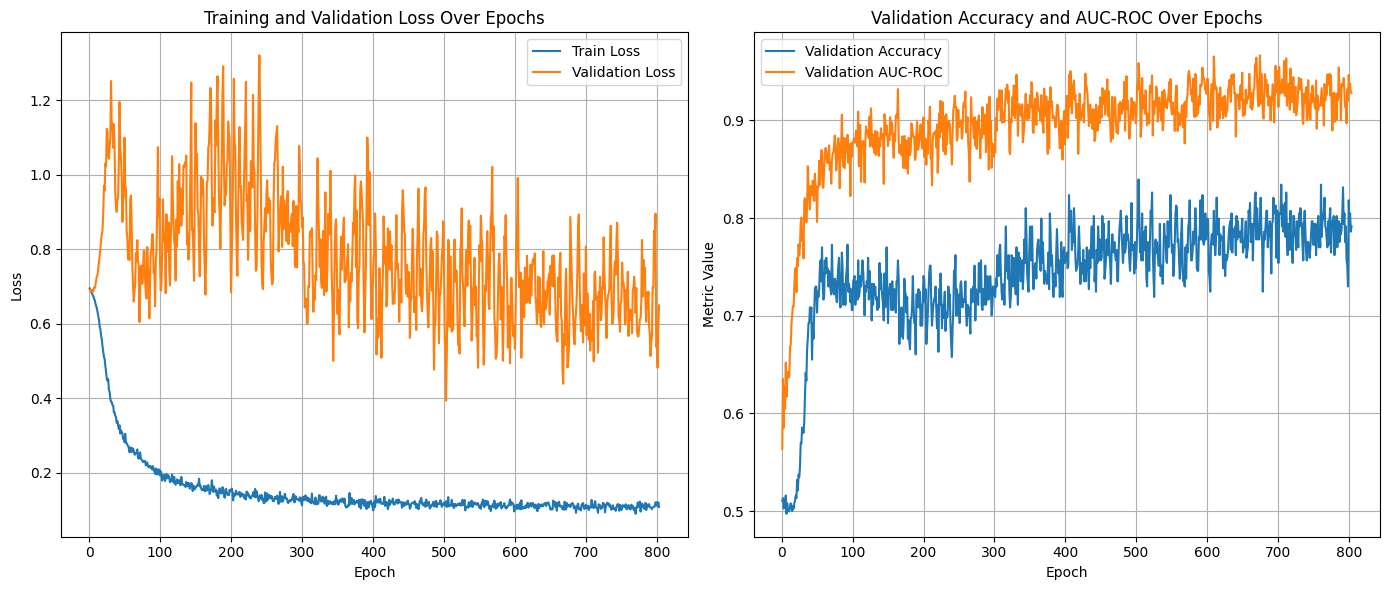

In [90]:
# Load the best model before final evaluation
model.load_state_dict(torch.load('best_link_prediction_model.pt'))
print("Loaded best model for final test evaluation.")

# Evaluation on Test Set
print("\n Evaluating on Test Set")
test_loss, test_acc, test_auc, test_predicted_labels, test_probabilities, test_true_labels, test_evaluated_edge_indices_global, test_derived_lineage_labels = lineage.evaluate_dynamic(model,
                                                                                                                                                                                       test_loader,
                                                                                                                                                                                       criterion,
                                                                                                                                                                                       device, 
                                                                                                                                                                                       neg_sample_ratio=1,
                                                                                                                                                                                       node_lineage_map=node_lineage_dict)


print(f"Final Test Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, AUC-ROC: {test_auc:.4f}")

# Plotting the Results
epochs_range = range(1, len(train_losses) + 1) 

plt.figure(figsize=(14, 6)) 

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy and AUC-ROC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, val_aucs, label='Validation AUC-ROC')
plt.title('Validation Accuracy and AUC-ROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Convert tensors to lists for DataFrame construction
source_nodes = test_evaluated_edge_indices_global[0].tolist()
destination_nodes = test_evaluated_edge_indices_global[1].tolist()
predicted_probabilities = test_probabilities.tolist()
predicted_binary_labels = test_predicted_labels.tolist()
true_binary_labels = test_true_labels.tolist()
derived_lineage_labels = test_derived_lineage_labels

data_for_df = {
    'Source_Node': source_nodes,
    'Destination_Node': destination_nodes,
    'Predicted_Probability': predicted_probabilities,
    'Predicted_Label': predicted_binary_labels,
    'True_Label': true_binary_labels,
    'Derived_lineage': derived_lineage_labels
}
df_predictions = pd.DataFrame(data_for_df)

# Plot predicted vs ground truth lineage for test kymographs

In [57]:
import networkx as nx

In [65]:
node_id_exp_info = df_for_training[['experiment_name', 'FOV', 'trench_id', 'track_id', 'node_id',
       'ground_truth_lineage', 'gene', 'unique_lineages', 'numeric_lineage']].copy()

In [67]:
test_predictions_node_info = df_predictions.merge(node_id_exp_info, left_on = 'Source_Node', right_on = 'node_id')

In [72]:
unique_fovs = test_predictions_node_info[['experiment_name', 'FOV', 'trench_id']].drop_duplicates().to_records(index=False)

In [74]:
exp, fov, trench = unique_fovs[0]

In [98]:
df_filtered_predictions = test_predictions_node_info[
    (test_predictions_node_info['experiment_name'] == exp) &
    (test_predictions_node_info['FOV'] == fov) &
    (test_predictions_node_info['trench_id'] == trench) &
    (test_predictions_node_info['Predicted_Probability'] >= 0.8)].copy()

In [79]:
G = nx.DiGraph()
for _, row in df_filtered_predictions.iterrows():
    source = row['Source_Node']
    dest = row['Destination_Node']
    prob = row['Predicted_Probability']
    # Add the edge with the probability as an attribute
    G.add_edge(source, dest, prob=prob)

print("Initial graph:")
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# Iteratively find and remove the weakest edge in a cycle until no cycles remain.
while True:
    # Get a list of all simple cycles. If this list is empty, we are done.
    try:
        # Get the first cycle found. You don't need all of them at once.
        cycle = next(nx.simple_cycles(G))
        
        weakest_edge = None
        min_prob = float('inf')

        # Find the weakest edge in the current cycle
        for i in range(len(cycle)):
            u = cycle[i]
            v = cycle[(i + 1) % len(cycle)]
            
            # Check if the edge exists and get its probability
            # Some edges might have been removed in a previous iteration
            if G.has_edge(u, v):
                current_prob = G.edges[u, v]['prob']
                if current_prob < min_prob:
                    min_prob = current_prob
                    weakest_edge = (u, v)

        # If a weakest edge was found, remove it
        if weakest_edge:
            print(f"Removing edge {weakest_edge} with probability {min_prob} to break a cycle.")
            G.remove_edge(*weakest_edge)

    except StopIteration:
        # No more cycles found, so we can exit the loop
        break

print("\nAll cycles have been removed.")
print(f"Final graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Initial graph:
Nodes: 245, Edges: 255
Removing edge (9486, 9516) with probability 0.9874163866043091 to break a cycle.
Removing edge (9390, 9381) with probability 0.9839528203010559 to break a cycle.

All cycles have been removed.
Final graph has 245 nodes and 253 edges.


In [80]:
try:
    # networkx.find_cycle will raise NetworkXNoCycle if no cycle is found
    cycle_path = nx.find_cycle(G)
    print(f"ERROR: Graph contains a cycle! Example cycle: {cycle_path}")
    # You might want to break here or handle the cycle detection
    # For lineage analysis, cycles are usually invalid data.
except nx.NetworkXNoCycle:
    print("Graph is a DAG (no cycles detected).")

Graph is a DAG (no cycles detected).


In [81]:
branches = lineage.find_lineage_branches(G)

--- Function find_lineage_branches_optimized_v3 started ---
Step 1: Identifying root nodes...
Step 1 Complete: Found 11 root nodes. Roots: [9446, 9512, 9315, 9381, 9464]...
Step 2: Initializing stack...
Step 2 Complete: Stack initialized with 11 items.
Step 3: Entering main traversal loop...
Processing node: 9404, current segment length: 1
  Segment started from: 9404
  Node 9404 is a straight-line node.
Processing node: 9401, current segment length: 2
  Segment started from: 9404
  Node 9401 is a straight-line node.
Processing node: 9382, current segment length: 3
  Segment started from: 9404
  Node 9382 is a straight-line node.
Processing node: 9388, current segment length: 4
  Segment started from: 9404
  Node 9388 is a straight-line node.
Processing node: 9387, current segment length: 5
  Segment started from: 9404
  Node 9387 is a straight-line node.
Processing node: 9383, current segment length: 6
  Segment started from: 9404
  Node 9383 is a straight-line node.
Processing node: 

In [97]:
branches[10]

{'type': 'segment_to_leaf', 'path': [9257, 9255, 9251, 9246]}

In [27]:
def plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, full_region_df, folder, fov_id, peak_id, fig_dir, track_id_col='track_id'):
    fig, ax = plt.subplots(2,1, figsize=(40, 10))

    # Get kymograph shape once for both calls
    kymograph_shape = phase_kymograph.shape

    ax[0].imshow(phase_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[0], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title(f'Phase Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    ax[1].imshow(fluor_kymograph, cmap = 'grey')
    _plot_cell_masks(ax[1], full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = track_id_col)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_title(f'Fluorescence Kymograph - {folder} FOV: {fov_id}, trench: {peak_id}')

    plt.xlabel("Time frames")
    plt.tight_layout()
    #plt.savefig(fig_dir)
    #plt.close(fig)

def _plot_cell_masks(ax, full_region_df, kymograph_shape, y_coord_col = 'centroid_y', x_coord_col = 'centroid_x', lineage_col = None):
    default_cell_contour_color = '#AA5486'
    default_centroid_color = '#FC8F54'
    text_color = 'white' # Color for the track ID text
    text_offset_x = 5 # Offset the text slightly from the centroid to avoid overlap
    text_offset_y = 0

    # Prepare data for LineCollection for contours
    all_contours_segments = []
    all_contour_colors = []
    
    # Prepare data for centroids
    centroid_x_coords = []
    centroid_y_coords = []
    centroid_colors = []

    all_text_params = []

    if lineage_col:
        unique_track_ids = full_region_df[lineage_col].dropna().unique()
        colors_cmap = plt.get_cmap('tab20', len(unique_track_ids))
        track_colors = {track_id: colors_cmap(i) for i, track_id in enumerate(unique_track_ids)}

    for index, region_props in full_region_df.iterrows():
        # 'coords' are assumed to be (row, col) pixels within the mask
        cell_pixel_coords = np.array(region_props['coords']) # e.g., [[r1,c1], [r2,c2], ...]

        # Calculate bounding box for the current cell's mask
        min_row, min_col = np.min(cell_pixel_coords, axis=0)
        max_row, max_col = np.max(cell_pixel_coords, axis=0)

        # Create a small temporary mask for the current cell
        # Add a small buffer to ensure contours are fully captured if they go to edge
        buffer = 1
        bbox_min_row = max(0, min_row - buffer)
        bbox_min_col = max(0, min_col - buffer)
        bbox_max_row = min(kymograph_shape[0], max_row + buffer)
        bbox_max_col = min(kymograph_shape[1], max_col + buffer)

        temp_mask_shape = (bbox_max_row - bbox_min_row + 1, bbox_max_col - bbox_min_col + 1)
        temp_mask = np.zeros(temp_mask_shape, dtype=np.uint8)

        # Map cell_pixel_coords to relative coordinates within temp_mask
        relative_rows = cell_pixel_coords[:, 0] - bbox_min_row
        relative_cols = cell_pixel_coords[:, 1] - bbox_min_col
        
        # Populate the temporary mask
        temp_mask[relative_rows, relative_cols] = 1

        # Find contours on this small temporary mask
        # level=0.5 means it finds contours at the boundary between 0 and 1
        # fully_connected='high' means it considers 8-connectivity for background, 4-connectivity for foreground
        contours = find_contours(temp_mask, level=0.5, fully_connected='high')

        if not contours:
            continue # Skip if no contour found (e.g., single pixel or degenerate mask)

        # `find_contours` returns (row, col) coordinates for the contour.
        # We need to convert them back to global kymograph coordinates.
        # And convert to (x, y) for plotting (col, row)
        global_contours = []
        for contour in contours:
            # Shift back to global coordinates and swap for (x, y) plotting
            global_contour_x = contour[:, 1] + bbox_min_col
            global_contour_y = contour[:, 0] + bbox_min_row
            global_contours.append(np.vstack([global_contour_x, global_contour_y]).T)

        y_coord = region_props[y_coord_col]
        x_coord = region_props[x_coord_col]
        
        # Determine color for the current cell
        if lineage_col and region_props[lineage_col] in track_colors:
            current_color = track_colors[region_props[lineage_col]]
        else:
            current_color = default_cell_contour_color

        # Add all contours for this cell to the main list, with the determined color
        for contour_segment in global_contours:
            all_contours_segments.append(contour_segment)
            all_contour_colors.append(current_color)
            
        # Add centroid data
        centroid_x_coords.append(x_coord)
        centroid_y_coords.append(y_coord)
        centroid_colors.append(current_color if lineage_col else default_centroid_color)
        
        # --- Add Track ID Text ---
        if lineage_col and pd.notna(region_props[lineage_col]):
            track_id = region_props[lineage_col]
            # Convert track_id to int if it's a float, for cleaner display
            if isinstance(track_id, float) and track_id.is_integer():
                track_id_display = int(track_id)
            else:
                track_id_display = track_id

            all_text_params.append({
                'x': x_coord + text_offset_x,
                'y': y_coord + text_offset_y,
                's': str(track_id_display),
                'color': text_color,
                'fontsize': 8,
                'ha': 'left', # horizontal alignment
                'va': 'center', # vertical alignment
                'bbox': dict(facecolor=current_color, edgecolor='none', alpha=0.6, pad=1.0) # Background box
            })

    # Plot all cell contours at once using LineCollection
    if all_contours_segments: # Only plot if there are segments to draw
        line_collection = LineCollection(all_contours_segments, colors=all_contour_colors, linewidths=0.5)
        ax.add_collection(line_collection)

    # Plot all centroids at once using scatter
    if centroid_x_coords: # Only plot if there are centroids
        ax.scatter(centroid_x_coords, centroid_y_coords, color=centroid_colors, s=5, zorder=2)
    # Plot all track ID text at once
    for params in all_text_params:
        ax.text(params['x'], params['y'], params['s'], color=params['color'],
                fontsize=params['fontsize'], ha=params['ha'], va=params['va'],
                bbox=params['bbox'])

In [ ]:
for exp, fov, trench in unique_fovs:
    
    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/{fov}_{trench}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}//hyperstacked/drift_corrected/fast4deg_drift_corrected/rotated/mm_channels/subtracted/fluor/{fov}_{trench}.tif'
    
    
    path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/{fov}_{trench}.tif'
    path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/fluor/{fov}_{trench}.tif'
    
    # path_to_phase_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}/kymographs/phase/{fov}_{trench}.tif'
    # path_to_fluor_kymograph = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/{exp}//kymographs/fluor/{fov}_{trench}.tif'

    if os.path.exists(path_to_phase_kymograph) and os.path.exists(path_to_fluor_kymograph):

        phase_kymograph = tifffile.imread(path_to_phase_kymograph)
        fluor_kymograph = tifffile.imread(path_to_fluor_kymograph)
        df_view = df_for_training[df_for_training['experiment_name'].isin([exp]) &
                                  df_for_training['FOV'].isin([fov]) &
                                  df_for_training['trench_id'].isin([trench])
            ].copy()


        for i in range(10,30):
            branch = branches[i]

            print(branch['type'])
            plot_kymograph_cells_id(phase_kymograph, fluor_kymograph, 
                                            df_view[df_view['node_id'].isin(branch['path'])], 
                                            exp, fov, trench, 
                                            None, 
                                            track_id_col='node_id')